For November, the focus is getting this into a presentable status and reaching 90%+ accuracy

In [25]:
import numpy as np
import os
import PIL
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2 #opencv
import seaborn as sns
import plotly.express as px

from tensorflow import keras
from keras import layers
from keras.models import Sequential

from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
#load data
import PIL.Image
from pathlib import Path

c_path = Path("C:\\Users\\Miles\\Desktop\\JOADEM project\\DATA_Maguire_20180517_ALL\\DATA_Maguire_20180517_ALL\\SDNET2018\\P\\CP")
u_path = Path("C:\\Users\\Miles\\Desktop\\JOADEM project\\DATA_Maguire_20180517_ALL\\DATA_Maguire_20180517_ALL\\SDNET2018\\P\\UP")


In [27]:
import pathlib
c_list_data = list() # create a list for the c_image data
#read through it using a loop
for img in os.listdir(c_path):
  photo = cv2.imread(os.path.join(c_path, img)) #read the image
  photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB) #adjust the color to RGB
  photo = cv2.resize(photo, (256,256)) 
  photo = np.array(photo) #convert into a list
  c_list_data.append([photo, 0]) #append to c_list

u_list_data = list()
for img in os.listdir(u_path):
  photo = cv2.imread(os.path.join(u_path, img))
  photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
  photo = cv2.resize(photo, (256,256))
  photo = np.array(photo)
  u_list_data.append([photo, 1])


#then the training set will be those images combined

training_set = c_list_data + u_list_data

In [28]:
path = Path("C:\\Users\\Miles\\Desktop\\JOADEM project\\DATA_Maguire_20180517_ALL\\DATA_Maguire_20180517_ALL\\SDNET2018\\P")
np.save(os.path.join(path, 'labels'), np.array(training_set, dtype=object))
saved = np.load(os.path.join(path, 'labels.npy'), allow_pickle=True)



In [29]:
#display the image
print(np.shape(saved))

data_rows = saved[:,0]
data_list=[]
print(np.shape(saved[0][0]))
for row in range(len(saved)):
  saved[row][0] = np.reshape(saved[row][0], (256*256*3))

(24334, 2)
(256, 256, 3)


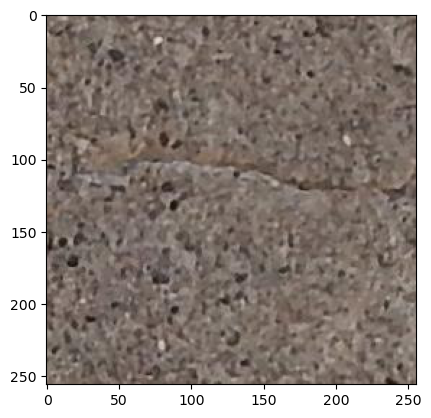

In [30]:
plt.imshow(np.array(training_set[0][0]))

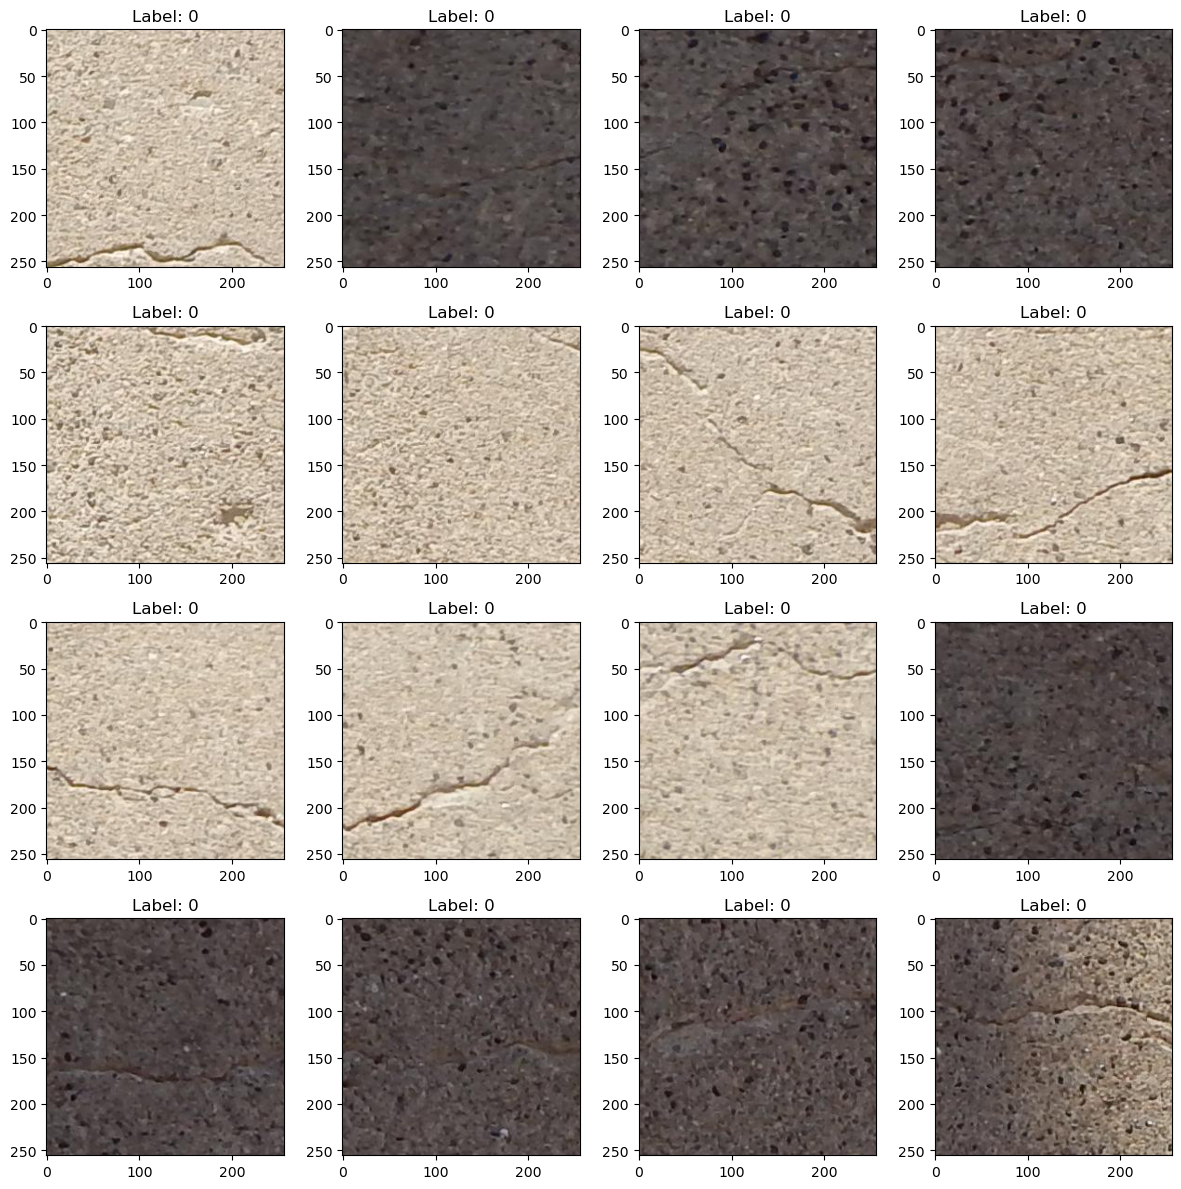

In [31]:
#now to view a mix of the dataset
fig, axes = plt.subplots(4,4, figsize=(12,12))
img = 26
for row in range(4):
  for col in range(4):
    a = np.reshape(saved[img][0], (256,256,3))
    axes[row,col].imshow(a)
    axes[row,col].set_title("Label: " + str(saved[img][1]))
    img+=1
fig.tight_layout()

In [32]:
#create dataframes
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob('*.jpg')), name='Filepath').astype(str)
    print(len(list(image_dir.glob('*.jpg'))))
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [33]:
cracked_df = generate_df(c_path, label="CRACKED")
uncracked_df = generate_df(u_path, label="UNCRACKED")

all_df = pd.concat([cracked_df, uncracked_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

2608
21726


,Filepath,Label
0,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
1,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
2,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
3,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
4,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
...,...,...
24329,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
24330,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
24331,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
24332,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED


In [186]:
from sklearn.utils import resample

#combine into main dataframe
cracked = all_df[all_df['Label'] == 'CRACKED']
uncracked = all_df[all_df['Label'] == 'UNCRACKED']

#upsample/downsample accordingly so that data is balanced
#lowered it down to 10000 (5000 each group)
training_cracked_upsample = resample(all_df['Label'] == 'CRACKED', replace=True, n_samples=20000, random_state=123)
cracked_resample = resample(cracked, replace=True, n_samples=10000, random_state=123)
uncracked_resample = resample(uncracked, replace=True, n_samples=10000, random_state=123)

In [187]:
#cracked_df = generate_df(c_path, label="CRACKED")
#uncracked_df = generate_df(u_path, label="UNCRACKED")


all_df = pd.concat([cracked_resample, uncracked_resample], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
1,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
2,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,CRACKED
3,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
4,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,CRACKED
...,...,...
19995,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
19996,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
19997,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,CRACKED
19998,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED


In [188]:
from sklearn.model_selection import train_test_split
#create train and test data
train_df, test_df = train_test_split(
    all_df,
    train_size=0.8,
    shuffle=True,
    random_state=1
)


train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)
print(train_df.shape, test_df.shape)

#load image data
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True
#     brightness_range=[0.2,1.2]

)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)



(16000, 3) (4000, 3)


In [189]:
train_df['Label'].value_counts()

Label
UNCRACKED    8000
CRACKED      8000
Name: count, dtype: int64

In [190]:
all_df['Label'].value_counts()

Label
UNCRACKED    10000
CRACKED      10000
Name: count, dtype: int64

In [191]:
test_df.count()

index       4000
Filepath    4000
Label       4000
dtype: int64

In [192]:
# from keras.utils import to_categorical
# train_df['Label'] = to_categorical(train_df.Label == "CRACKED")

In [193]:
#use data augmentation to prevent overfitting after putting more data
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256), #change to 256 11/13
    #target_size=(64,64),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    #target_size=(64,64),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
     shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    #target_size=(64,64),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
    shuffle=False,
    seed=42
)

Found 12000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.



the model below was altered to have augmentation, the pixel size was increased, and another layer was added. 


In [200]:
from tensorflow.keras.layers.experimental import preprocessing

model = tf.keras.Sequential(
    [



    tf.keras.layers.Conv2D(16, (5,5), padding='same', activation="relu",input_shape=(256, 256, 3)),  #(the (3,3) is the kernal dimensions, this can be played around with )
    tf.keras.layers.MaxPooling2D((3,3), strides=5),
    
    #tf.keras.layers.Conv2D(16, (3,3), padding='same', activation="relu"),
    #tf.keras.layers.MaxPooling2D((5,5), strides=5),

    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=3),
        
    #tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu"),
    #tf.keras.layers.MaxPooling2D((2, 2), strides=3),
        

    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((3,3), strides=3),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=3),
    tf.keras.layers.Dropout(0.25),


    #this extra layer has been added 11/8

     tf.keras.layers.Conv2D(256, (5,5), padding='same', activation="relu"),
     tf.keras.layers.MaxPooling2D((2, 2), strides=5),
     tf.keras.layers.Dropout(0.25),
        
     

    # Preprocessing layers for augmentation
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomFlip('vertical'), #flip vertically
    preprocessing.RandomZoom(.5, .2), #randomly zooms into an image
    #preprocessing.RandomContrast(factor=0.2), #randomly change contrast by up to 20%
    preprocessing.RandomTranslation(fill_mode="nearest", height_factor=0.4, width_factor=0.4), #randomly apply translations (Translation just involves moving the image along the X or Y direction (or both)) to each image, filling empty space. The input is extended by the nearest pixel in this case.


    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(256, activation="relu"), #try different dense layer number
    tf.keras.layers.Dense(128, activation="relu"), #try different dense layer number
    tf.keras.layers.Dense(1, activation="sigmoid")
]
)

In [201]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_170 (Conv2D)         (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d_159 (MaxPool  (None, 51, 51, 16)        0         
 ing2D)                                                          
                                                                 
 conv2d_171 (Conv2D)         (None, 51, 51, 32)        12832     
                                                                 
 max_pooling2d_160 (MaxPool  (None, 17, 17, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_172 (Conv2D)         (None, 17, 17, 64)        51264     
                                                                 
 max_pooling2d_161 (MaxPool  (None, 5, 5, 64)        

In [202]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [203]:
#use BinaryCrossentropy for loss since this is binary classification 
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate = 0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [204]:

STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
STEP_SIZE_VALID=val_data.n//val_data.batch_size
STEP_SIZE_TEST=test_data.n//test_data.batch_size


#change batch size and num epochs so it runs faster. Might also help to resize the images
#to improve the performance, extend steps for each epoch and validation


history = model.fit(train_data,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_data,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=200
)



#the one below is for quick tests, otherwise it takes a while for it to go through each epoch
"""
history = model.fit(train_data,
                    steps_per_epoch = 750,
                    validation_data=val_data,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=200
)
"""

Epoch 1/200
750/750 [==============================] - 234s 310ms/step - loss: 0.6600 - accuracy: 0.5852 - val_loss: 0.5799 - val_accuracy: 0.6988
Epoch 2/200
750/750 [==============================] - 233s 310ms/step - loss: 0.5664 - accuracy: 0.7118 - val_loss: 0.5410 - val_accuracy: 0.7412
Epoch 3/200
750/750 [==============================] - 232s 309ms/step - loss: 0.5323 - accuracy: 0.7438 - val_loss: 0.5085 - val_accuracy: 0.7605
Epoch 4/200
750/750 [==============================] - 231s 308ms/step - loss: 0.5101 - accuracy: 0.7611 - val_loss: 0.5071 - val_accuracy: 0.7610
Epoch 5/200
750/750 [==============================] - 231s 308ms/step - loss: 0.4991 - accuracy: 0.7649 - val_loss: 0.4756 - val_accuracy: 0.7772
Epoch 6/200
750/750 [==============================] - 230s 307ms/step - loss: 0.4822 - accuracy: 0.7750 - val_loss: 0.4715 - val_accuracy: 0.7757
Epoch 7/200
750/750 [==============================] - 232s 309ms/step - loss: 0.4799 - accuracy: 0.7814 - val_loss: 0

750/750 [==============================] - 230s 306ms/step - loss: 0.3563 - accuracy: 0.8520 - val_loss: 0.3451 - val_accuracy: 0.8575
Epoch 57/200
750/750 [==============================] - 230s 306ms/step - loss: 0.3543 - accuracy: 0.8505 - val_loss: 0.3442 - val_accuracy: 0.8525
Epoch 58/200
750/750 [==============================] - 230s 307ms/step - loss: 0.3547 - accuracy: 0.8526 - val_loss: 0.3570 - val_accuracy: 0.8495
Epoch 59/200
750/750 [==============================] - 230s 306ms/step - loss: 0.3425 - accuracy: 0.8568 - val_loss: 0.3459 - val_accuracy: 0.8490
Epoch 60/200
750/750 [==============================] - 230s 306ms/step - loss: 0.3487 - accuracy: 0.8542 - val_loss: 0.3568 - val_accuracy: 0.8453
Epoch 61/200
750/750 [==============================] - 230s 307ms/step - loss: 0.3470 - accuracy: 0.8568 - val_loss: 0.3293 - val_accuracy: 0.8553
Epoch 62/200
750/750 [==============================] - 231s 308ms/step - loss: 0.3470 - accuracy: 0.8537 - val_loss: 0.3426 

750/750 [==============================] - 231s 308ms/step - loss: 0.3075 - accuracy: 0.8759 - val_loss: 0.3107 - val_accuracy: 0.8683
Epoch 112/200
750/750 [==============================] - 231s 308ms/step - loss: 0.3090 - accuracy: 0.8745 - val_loss: 0.3054 - val_accuracy: 0.8692
Epoch 113/200
750/750 [==============================] - 233s 311ms/step - loss: 0.3045 - accuracy: 0.8756 - val_loss: 0.2882 - val_accuracy: 0.8790
Epoch 114/200
750/750 [==============================] - 232s 309ms/step - loss: 0.3117 - accuracy: 0.8738 - val_loss: 0.2878 - val_accuracy: 0.8808
Epoch 115/200
750/750 [==============================] - 259s 346ms/step - loss: 0.3060 - accuracy: 0.8766 - val_loss: 0.2954 - val_accuracy: 0.8800
Epoch 116/200
750/750 [==============================] - 235s 313ms/step - loss: 0.2984 - accuracy: 0.8776 - val_loss: 0.3048 - val_accuracy: 0.8662
Epoch 117/200
750/750 [==============================] - 229s 305ms/step - loss: 0.3003 - accuracy: 0.8764 - val_loss: 0

750/750 [==============================] - 230s 307ms/step - loss: 0.3495 - accuracy: 0.8604 - val_loss: 0.3089 - val_accuracy: 0.8735
Epoch 167/200
750/750 [==============================] - 231s 308ms/step - loss: 0.3040 - accuracy: 0.8771 - val_loss: 0.2900 - val_accuracy: 0.8785
Epoch 168/200
750/750 [==============================] - 231s 308ms/step - loss: 0.2927 - accuracy: 0.8808 - val_loss: 0.2935 - val_accuracy: 0.8758
Epoch 169/200
750/750 [==============================] - 231s 308ms/step - loss: 0.2911 - accuracy: 0.8821 - val_loss: 0.2781 - val_accuracy: 0.8850
Epoch 170/200
750/750 [==============================] - 231s 308ms/step - loss: 0.2857 - accuracy: 0.8823 - val_loss: 0.2597 - val_accuracy: 0.8963
Epoch 171/200
750/750 [==============================] - 232s 309ms/step - loss: 0.2812 - accuracy: 0.8848 - val_loss: 0.2799 - val_accuracy: 0.8855
Epoch 172/200
750/750 [==============================] - 233s 310ms/step - loss: 0.2777 - accuracy: 0.8877 - val_loss: 0

'\nhistory = model.fit(train_data,\n                    steps_per_epoch = 750,\n                    validation_data=val_data,\n                    validation_steps=STEP_SIZE_VALID,\n                    epochs=200\n)\n'

In [205]:
metrics_df = pd.DataFrame(history.history)

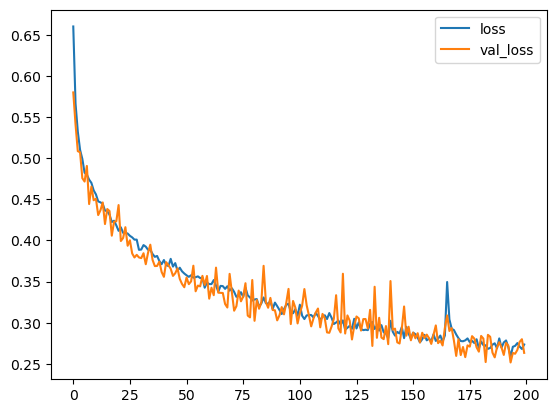

In [206]:
metrics_df[["loss","val_loss"]].plot();

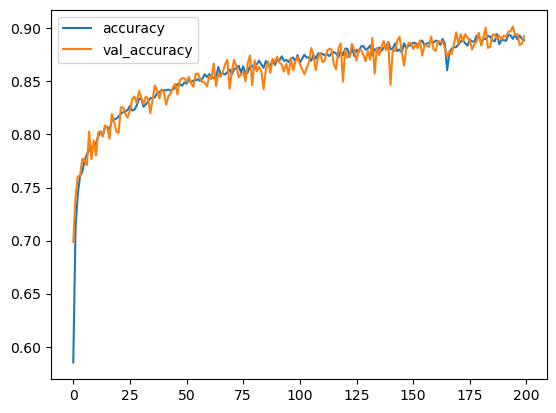

In [207]:

metrics_df[["accuracy","val_accuracy"]].plot();


moral of the story - colab is great for small collaboration projects. the bigger the project gets, the less reliable colab is

In [208]:
test_df


,index,Filepath,Label
0,11456,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
1,16528,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED
2,3253,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,CRACKED
3,18614,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,CRACKED
4,1544,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,CRACKED
...,...,...,...
3995,6375,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,CRACKED
3996,14837,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,CRACKED
3997,3931,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,CRACKED
3998,18266,C:\Users\Miles\Desktop\JOADEM project\DATA_Mag...,UNCRACKED


In [ ]:
#model_predictions.shape

In [ ]:
#model_predictions[:,1]

In [ ]:
#model_predictions_cracked, model_predictions_uncracked = pd.Series(model_predictions[:,0]), pd.Series(model_predictions[:,1])

In [ ]:
#test_df['model_prediction'] = (model_predictions_cracked > model_predictions_uncracked)

In [ ]:
#test_df['gt_bool'] = (test_df['Label'] == 'CRACKED')

In [209]:
#results

def evaluate_model(model, test_data):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["UNCRACKED", "CRACKED"])

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["UNCRACKED", "CRACKED"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["UNCRACKED", "CRACKED"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    print("Classification Report:\n----------------------\n", clr)

the matrix still takes a long time

    Test Loss: 0.25775
Test Accuracy: 89.60%
250/250 [==============================] - 40s 161ms/step


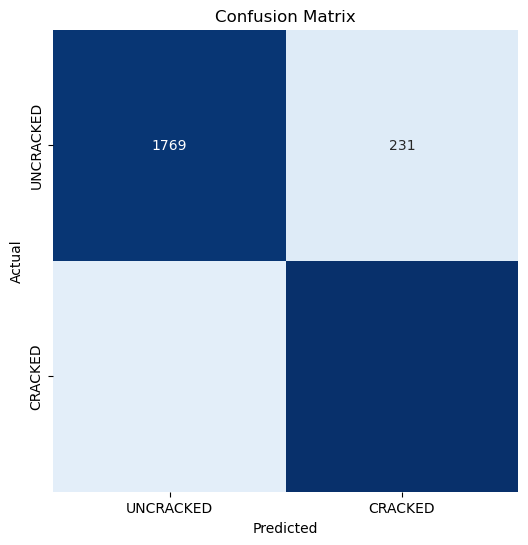

Classification Report:
----------------------
               precision    recall  f1-score   support

   UNCRACKED       0.91      0.88      0.90      2000
     CRACKED       0.89      0.91      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



In [210]:
evaluate_model(model,test_data)


In [211]:
results = model.evaluate(test_data, verbose=0)
results

[0.2572788596153259, 0.8972499966621399]

In [212]:
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
cm = confusion_matrix(test_data.labels, y_pred)
cm
#it has the results for the bottom of the confusion matrix, but it's not showing in the actual plot. Why? 

250/250 [==============================] - 40s 161ms/step


array([[1759,  241],
       [ 181, 1819]], dtype=int64)

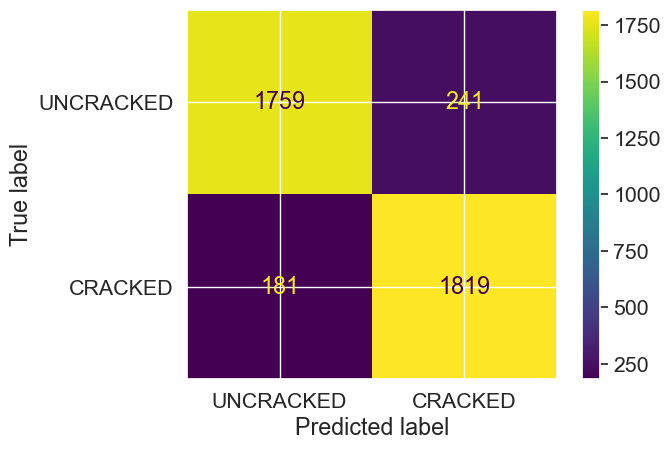

In [233]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["UNCRACKED", "CRACKED"])
disp.plot()

In [213]:
clr = classification_report(test_data.labels, y_pred, target_names=["UNCRACKED", "CRACKED"])
clr

'              precision    recall  f1-score   support\n\n   UNCRACKED       0.91      0.88      0.89      2000\n     CRACKED       0.88      0.91      0.90      2000\n\n    accuracy                           0.89      4000\n   macro avg       0.89      0.89      0.89      4000\nweighted avg       0.89      0.89      0.89      4000\n'

<Figure size 600x600 with 0 Axes>

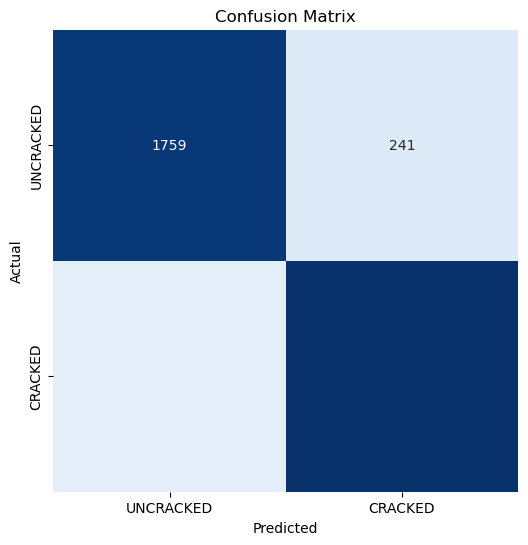

In [215]:
plt.figure(figsize=(6, 6))
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["UNCRACKED", "CRACKED"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["UNCRACKED", "CRACKED"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
#earlystopping to prevent overfitting

#from tensorflow.keras.callbacks import EarlyStopping
#callbacks = [
#            EarlyStopping(patience=2)
#]

In [ ]:
#save the best performing iteration. By default, it will save the models where the validation loss is minimum.
#checkpoint_filepath = '/tmp/checkpoint'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath,
#    save_weights_only=False,
#    monitor='loss',
#    mode='min',
 #   save_best_only=True)


In [ ]:
#add in dropout regularization as well to help with overfitting
#introduce the dropout layer
"""
#model = tf.keras.Sequential(
    [


    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation="softmax")


]
)
"""

In [ ]:
#compile again
"""
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

"""

In [ ]:
#history = model.fit(train_data, epochs=200,validation_data=val_data, callbacks=callbacks)


In [ ]:
#After training, you can load the model again using the Keras `load_model` utility. Uncomment the line below to use the saved model

#another_saved_model = tf.keras.models.load_model(checkpoint_filepath)


In [214]:
#visualize results
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()